# ML BENCHMARK FOR TREMOR CLASSIFICATION

Αρχικά κατασκευάζουμε το dataset προσομοιώνοντας ένα αληθινό EMG signal,
ενσωματώνοντας χαρακτηριστικά που εμφανίζονται σε πραγματικές καταγραφές από ανταγωνιστικούς μύες (extensor–flexor) κατά την εμφάνιση τρέμουλου.


Alternating pattern --> Οι δύο μύες κάνουν bursting σε διαφορετική φάση.
Πλάτος = 100–200 μV.
Συχνότητα = 4-8 Hz

---

Synchronous pattern --> Οι δύο μύες κάνουν bursting ταυτόχρονα.
Πλάτος = 50–150 μV.
Συχνότητα = 4-8 Hz.

Για να είναι πιο ρεαλιστικό προσθέτω αποκλίσεις για να μην είναι απόλυτα διαχωρίσιμο.


Επιπλέον, προσθέτω και άλλους θορύβους που υπάρχουν σε πραγματικά EMG όπως :
1) EMG background noise ( Gaussian 10 μV)
2) Powerline interference (50 Hz)
3) Baseline drift (0.1–0.3 Hz) λόγω ηλεκτροδίων
4) Cross talk μεταξύ των δυο μυών

Αφού προστεθούν οι θόρυβοι, εφαρμόζουμε ένα 4th-order Butterworth φίλτρο 20–450 Hz, ώστε να απομονώσουμε την καθαρή μυϊκή δραστηριότητα.

In [5]:
import numpy as np
import scipy.signal as signal

fs = 2000
duration = 10
T = int(fs * duration)

def bandpass(x):
  #4th order --> standar επιλογή για EMG
  #Όρια= 20 - 450 Hz γιατί το surface EMG έχει χρήσιμη πληροφορία σε αυτά τα V.
    b, a = signal.butter(4, [20/(fs/2), 450/(fs/2)], 'band')
    return signal.filtfilt(b, a, x)

def emg_burst(amplitude=150, width=0.04):
    L = int(width * fs)
    noise = np.random.randn(L)
    spike = amplitude * noise
    return spike

#προσθήκη θορύβου για να είναι ρεαλιστικό το dataset.
def add_powerline_and_baseline(x, fs):
    t = np.arange(len(x)) / fs

    # powerline 50 Hz με μικρή ένταση
    A50 = np.random.uniform(2, 8)
    phi = np.random.uniform(0, 2*np.pi)
    powerline = A50 * np.sin(2*np.pi*50*t + phi)

    # πολύ αργό baseline drift (0.1–0.3 Hz, πριν το high-pass)
    # προέρχεται από αγωγιμότητα δέρματος, μετακίνηση των ηλεκτροδίων κλπ
    f0 = np.random.uniform(0.1, 0.3)
    A0 = np.random.uniform(5, 20)
    baseline = A0 * np.sin(2*np.pi*f0*t + np.random.uniform(0, 2*np.pi))

    return x + powerline + baseline

def generate_tremor_pattern_10s(synchronous=True):
    ext = np.zeros(T)
    flex = np.zeros(T)

    # bursts περίπου ανά 0.15–0.3 s (4–6 Hz)
    inter_burst = np.random.uniform(0.15, 0.30)
    burst_times = np.arange(0.5, duration - 0.5, inter_burst)

    for bt in burst_times:
        idx = int(bt * fs)
        width = np.random.uniform(0.03, 0.07)
        amp = np.random.uniform(80, 200)
        b = emg_burst(amplitude=amp, width=width)

        # κάποιες φορές τα patterns μπερδεύονται επίτηδες
        p_misalign = 0.2   # 20% των bursts είναι "περίεργα"

        if synchronous:
            # ιδανικά ίδια φάση, αλλά με μικρό jitter
            delay = int(np.random.normal(0, 0.01) * fs)   # ~±10 ms

            # με πιθανότητα p_misalign, κάνε τα λίγο πιο "alternating"
            if np.random.rand() < p_misalign:
                delay = int(np.random.normal(0.05, 0.02) * fs)  # 50 ms περίπου

        else:
            # ιδανικά alternating, δηλ. ~60 ms delay
            delay = int(np.random.normal(0.06, 0.02) * fs)      # 60±20 ms

            # με πιθανότητα p_misalign κάνε σχεδόν synchronous
            if np.random.rand() < p_misalign:
                delay = int(np.random.normal(0, 0.01) * fs)     # ~0 ms

        # γράψε burst στον extensor
        if idx + len(b) < T:
            ext[idx:idx+len(b)] += b

        # γράψε burst στον flexor με delay (clip για ασφάλεια)
        j = idx + delay
        if 0 <= j < T:
            end = min(j+len(b), T)
            flex[j:end] += b[:end-j]

    # background EMG noise λίγο μεγαλύτερο
    ext += np.random.randn(T) * 10
    flex += np.random.randn(T) * 10

    # cross-talk: κάθε κανάλι "βλέπει" λίγο από το άλλο
    alpha = np.random.uniform(0.1, 0.3)
    ext_xt = ext + alpha * flex
    flex_xt = flex + alpha * ext

    # powerline + baseline drift (θα κοπούν εν μέρει από το φίλτρο)
    ext_noisy = add_powerline_and_baseline(ext_xt, fs)
    flex_noisy = add_powerline_and_baseline(flex_xt, fs)

    # τελικό EMG (με band-pass)
    return bandpass(ext_noisy), bandpass(flex_noisy)


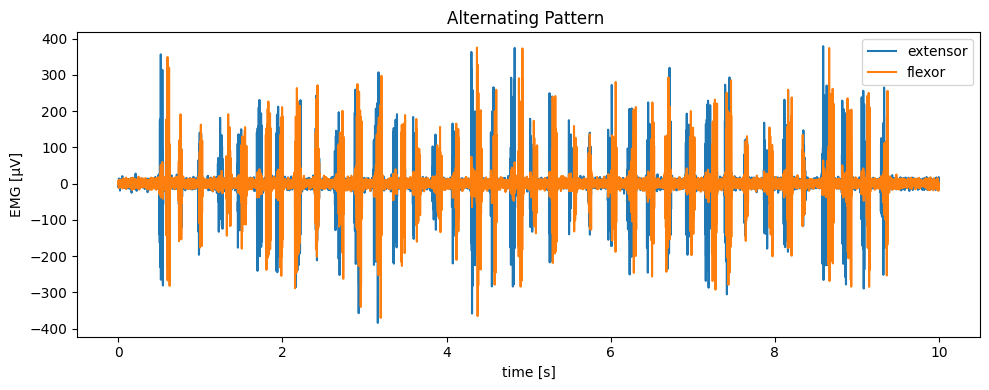

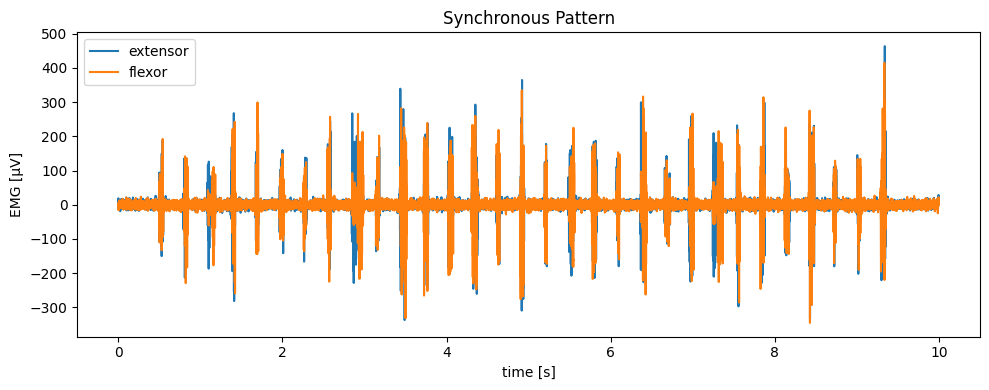

In [6]:
import matplotlib.pyplot as plt

def plot_two(ext, flex, title):
    t = np.arange(len(ext)) / fs

    plt.figure(figsize=(10,4))
    plt.plot(t, ext, label='extensor')
    plt.plot(t, flex, label='flexor')
    plt.title(title)
    plt.xlabel("time [s]")
    plt.ylabel("EMG [µV]")
    plt.legend()
    plt.tight_layout()
    plt.show()

# alternating
ext_alt, flex_alt = generate_tremor_pattern_10s(synchronous=False)
plot_two(ext_alt, flex_alt, "Alternating Pattern ")

# synchronous
ext_syn, flex_syn = generate_tremor_pattern_10s(synchronous=True)
plot_two(ext_syn, flex_syn, "Synchronous Pattern")


In [7]:
def generate_dataset(N=2000):
    X = np.zeros((N, 2, T))
    y = np.zeros(N)

    for i in range(N):
        label = np.random.randint(0, 2)    # 0 = A, 1 = S
        y[i] = label
        ext, flex = generate_tremor_pattern_10s(synchronous=(label==1))
        X[i,0] = ext
        X[i,1] = flex

    return X, y

X, y = generate_dataset(2000)


Στην συνέχεια, από κάθε σήμα εξάγουμε τα χαρακτηριστικά από:
1) time domain
2) frequency domain
3) burst patter
4) cross channel
5) χαρακτηριστικά tremor frequency

In [8]:
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.signal import welch, csd, coherence
from scipy.integrate import trapezoid

def bandpower_freq(Pxx, f, fmin, fmax):
    idx = (f >= fmin) & (f <= fmax)
    return trapezoid(Pxx[idx], f[idx])

def burst_stats(sig, fs):
    # Detect rectified bursts
    rect = np.abs(sig)
    thr = np.percentile(rect, 90)
    burst = rect > thr

    # Burst rate
    rate = np.sum(np.diff(burst.astype(int)) == 1) / (len(sig)/fs)

    # Burst amplitudes
    amps = rect[burst]
    amp_mean = np.mean(amps) if len(amps)>0 else 0

    # Burst duration
    dur = np.sum(burst) / fs

    return rate, amp_mean, dur

def extract_features(ext, flex):
    feats = []

    for sig in [ext, flex]:

        # time domain
        feats += [
            #ένταση σήματος
            np.mean(sig),
            np.std(sig),
            np.sqrt(np.mean(sig**2)),  #RMS
            np.var(sig),
            #ασυμμετρία στο ιστόγραμμα
            skew(sig),
            kurtosis(sig),
            np.sum(np.diff(np.sign(sig)) != 0),
            np.sum(np.abs(np.diff(sig))), #waveform length
            np.max(sig), np.min(sig),
            np.ptp(sig)
        ]

        # Hjorth --> κινητικότητα και πολυπλοκότητα
        dx = np.diff(sig)
        ddx = np.diff(dx)
        var0 = np.var(sig)
        var1 = np.var(dx)
        var2 = np.var(ddx)
        mobility = np.sqrt(var1 / (var0 + 1e-12))
        complexity = np.sqrt(var2 / (var1 + 1e-12))
        feats += [mobility, complexity]

        # frequency domain
        f, Pxx = welch(sig, fs=fs, nperseg=2048)
        centroid = np.sum(f * Pxx) / (np.sum(Pxx) + 1e-12)
        #περιγράφουν πόσο περιοδικό είναι το σήμα
        #και σε ποιες συχνότητες κάθονται οι bursts.
        feats += [
            f[np.argmax(Pxx)],      # peak freq
            centroid,
            bandpower_freq(Pxx, f, 4, 8),
            bandpower_freq(Pxx, f, 20, 50),
            bandpower_freq(Pxx, f, 50, 150),
            bandpower_freq(Pxx, f, 0, 500),
            np.max(Pxx),
            np.var(Pxx),
            -np.sum(Pxx * np.log(Pxx+1e-12)),
            np.mean(Pxx)/(np.max(Pxx)+1e-12)
        ]

    # cross-channel features
    f, Cxy = coherence(ext, flex, fs=fs) #Πόσο συγχρονισμένα είναι τα 2 EMG σήματα σε συχνότητα.
    feats.append(np.max(Cxy))

    f2, Pxy = csd(ext, flex, fs=fs)
    idx = np.argmax(np.abs(Pxy))
    feats.append(np.angle(Pxy[idx]))  #phase lag --> πολύ σημαντικό
    feats.append(np.abs(Pxy[idx]))
    feats.append(np.corrcoef(ext, flex)[0,1])

    # Tremor frequency diffs
    fE, PxxE = welch(ext, fs=fs)
    fF, PxxF = welch(flex, fs=fs)

    tremE = fE[np.argmax(PxxE)]
    tremF = fF[np.argmax(PxxF)]

    feats.append(tremE)
    feats.append(tremF)
    feats.append(np.abs(tremE - tremF))

    # Burst statistics (ext / flex)
    stats_ext = burst_stats(ext, fs)
    stats_flex = burst_stats(flex, fs)

    feats += list(stats_ext)
    feats += list(stats_flex)

    return np.array(feats)


In [9]:
X_feat = np.zeros((len(X), 59))

for i in range(len(X)):
    ext = X[i,0]
    flex = X[i,1]
    X_feat[i] = extract_features(ext, flex)

print("OK! X_feat shape =", X_feat.shape)


OK! X_feat shape = (2000, 59)


Random Forest Performance:
Accuracy:  0.8925
Precision: 0.8922
Recall:    0.8966
F1-score:  0.8943

Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89       197
         1.0       0.89      0.90      0.89       203

    accuracy                           0.89       400
   macro avg       0.89      0.89      0.89       400
weighted avg       0.89      0.89      0.89       400



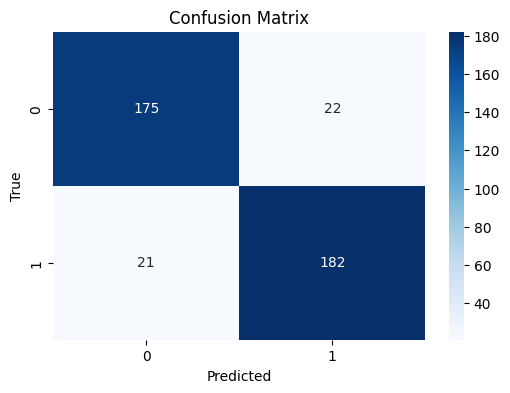

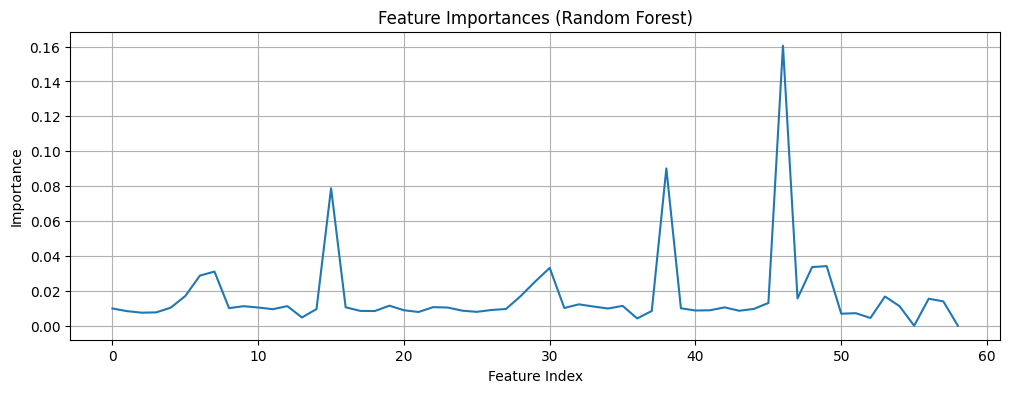

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_feat, y, test_size=0.2, random_state=42)

# Random Forest model
clf = RandomForestClassifier(n_estimators=300, max_depth=None, random_state=42)
clf.fit(X_train, y_train)

# Predictions
pred = clf.predict(X_test)

# --- METRICS ---
acc = accuracy_score(y_test, pred)
prec = precision_score(y_test, pred)
rec = recall_score(y_test, pred)
f1 = f1_score(y_test, pred)

print("Random Forest Performance:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")

# --- Classification report ---
print("\nClassification Report:")
print(classification_report(y_test, pred))

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# --- Feature Importances ---
importances = clf.feature_importances_
plt.figure(figsize=(12,4))
plt.plot(importances)
plt.title("Feature Importances (Random Forest)")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.grid(True)
plt.show()


Η ανάλυση των feature importances δείχνει ότι το πιο σημαντικό χαρακτηριστικό για τη διάκριση μεταξύ alternating και synchronous tremor είναι η φασική διαφορά (phase lag) μεταξύ των δύο EMG καναλιών. Αυτό είναι αναμενόμενο, επειδή στο synchronous pattern οι δύο μύες ενεργοποιούνται ταυτόχρονα, ενώ στο alternating εμφανίζεται σταθερή χρονική καθυστέρηση.

Δεύτερης σημασίας είναι ορισμένα συχνοτικά χαρακτηριστικά (π.χ. bandpower και peak frequency), τα οποία αποτυπώνουν την περιοδικότητα και την ενεργειακή κατανομή του τρέμουλου.

Τρίτης σημασίας ακολουθούν χαρακτηριστικά στο χρονικό πεδίο, όπως RMS και waveform length.

Συνολικά, το μοντέλο βασίζεται κυρίως στη φάση και στη φασματική πληροφορία για να ξεχωρίσει τα δύο είδη τρέμουλου.

XGBoost Performance:
Accuracy:  0.9350
Precision: 0.9403
Recall:    0.9310
F1-score:  0.9356

Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.94      0.93       197
         1.0       0.94      0.93      0.94       203

    accuracy                           0.94       400
   macro avg       0.93      0.94      0.93       400
weighted avg       0.94      0.94      0.94       400



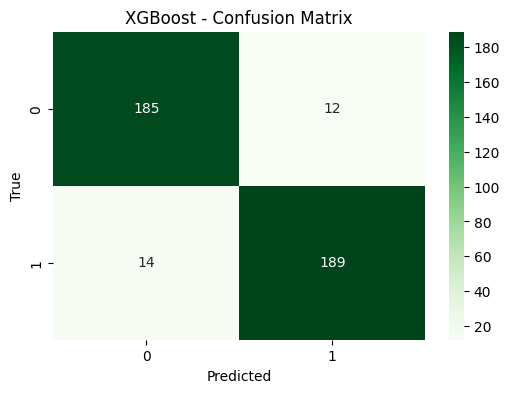

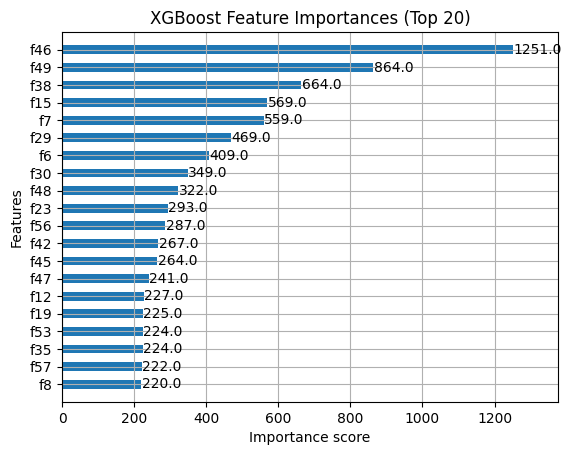

In [12]:
import xgboost as xgb
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt

model = xgb.XGBClassifier(
    n_estimators=500,  #500 δέντρα
    learning_rate=0.03,  #μικρά σταδιακά updates
    max_depth=6,  #ικανό να μάθει σύνθετεσ σχέσεις
    subsample=0.9,
    colsample_bytree=0.9  #τυχαιότητα στα χαρακτηριστικά, μειώνει overfitting
)

model.fit(X_train, y_train)
pred = model.predict(X_test)

# --- METRICS ---
acc = accuracy_score(y_test, pred)
prec = precision_score(y_test, pred)
rec = recall_score(y_test, pred)
f1 = f1_score(y_test, pred)

print("XGBoost Performance:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")

# --- Classification Report ---
print("\nClassification Report:")
print(classification_report(y_test, pred))

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, cmap="Greens", fmt="d")
plt.title("XGBoost - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# --- Feature Importance (gain-based) ---
xgb.plot_importance(model, max_num_features=20, height=0.5)
plt.title("XGBoost Feature Importances (Top 20)")
plt.show()

Από το παραπάνω γράφημα βλέπουμε ότι το πιο σημαντικό χαρακτηριστικό για τον XGBoost είναι το f46 δηλαδή το coherence που μετράει πόσο "συγχρονισμένα” είναι τα δύο EMG σήματα σε επίπεδο συχνότητας. Για S pattern --> coherence πολύ υψηλή.

Δεύτερο έρχεται το f49 που είναι το correlation μεταξύ των καναλιών. Η συσχέτιση είναι γενικά υψηλή όταν οι δύο μύες ενεργοποιούνται μαζί (synchronous) και χαμηλότερη όταν ενεργοποιούνται αντικριστά (alternating).

Συνολικά, ο XGBoost βασίζεται κυρίως στη συνεκτικότητα (coherence), στη συσχέτιση των δύο μυών και στα συχνοτικά στοιχεία για να διαχωρίσει αποτελεσματικά τα δύο είδη τρέμουλου.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │         1,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,482 (9.70 KB)

 Trainable params: 2,482 (9.70 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.4993 - loss: 0.7796 - val_accuracy: 0.5906 - val_loss: 0.6610
Epoch 2/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6567 - loss: 0.6043 - val_accuracy: 0.7188 - val_loss: 0.5469
Epoch 3/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7782 - loss: 0.4960 - val_accuracy: 0.8031 - val_loss: 0.4505
Epoch 4/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8310 - loss: 0.3928 - val_accuracy: 0.8469 - val_loss: 0.3902
Epoch 5/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8611 - loss: 0.3401 - val_accuracy: 0.8625 - val_loss: 0.3407
Epoch 6/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8862 - loss: 0.2893 - val_accuracy: 0.8656 - val_loss: 0.3050
Epoch 7/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9039 - loss: 0.2475 - val_accuracy: 0.8781 - val_loss: 0.2797
Epoch 8/35
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9154 - loss: 0.2254 - val_accuracy: 0.9000 - v

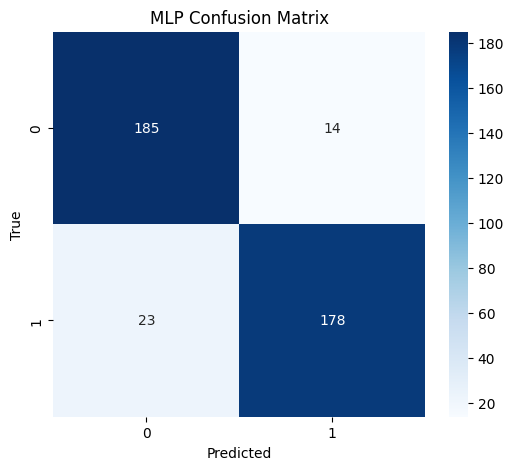

Model saved as mlp_tremor_classifier.h5


In [13]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns


# =============================
# 1. Split Data
# =============================
X_train, X_test, y_train, y_test = train_test_split(
    X_feat, y, test_size=0.2, random_state=42, stratify=y
)

# =============================
# 2. Normalize features
# =============================
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# =============================
# 3. Build MLP model με δυο νευρώνες
# =============================
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(59,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


# =============================
# 4. Train για 35 εποχές
# =============================
history = model.fit(
    X_train, y_train,
    epochs=35,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)


# =============================
# 5. Evaluate
# =============================
pred_probs = model.predict(X_test)
pred = np.argmax(pred_probs, axis=1)

acc = accuracy_score(y_test, pred)
prec = precision_score(y_test, pred)
rec = recall_score(y_test, pred)
f1 = f1_score(y_test, pred)

print("\nMLP PERFORMANCE")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, pred))

cm = confusion_matrix(y_test, pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("MLP Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# =============================
# 6. OPTIONAL: Save model για inference se pico
# =============================
model.save("mlp_tremor_classifier.h5")
print("Model saved as mlp_tremor_classifier.h5")
